In [13]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from re_forecast.data.get_data import get_rte_data
from re_forecast.preprocessing.preprocess_data import preprocess_data
from re_forecast.exploration.plot import plot_time_serie

# Training with SARIMA

Objectives of this notebook :  
- Base steps :  
  - Import data
  - Impute missing values
  - Develop a basic train/test split function for time series
- Baseline :  
  - Compute a baseline score
- Stationarity :  
  - Test for stationarity with an Augmented Dickey-Fuller (ADF) test
  - Preprocess the data and iterate with the computation of the ADF
- ARIMA :  
  - Plot the ACF and the PACF graphs and determine the coefficient for the ARIMA (and later SARIMA) models
  - Test different configurations of ARIMA models
  - Plot the forecast results against test values

## Base steps

Steps :
- Import data
- Impute missing values
- Develop a basic train/test split function for time series

In [14]:
# Set the parameters
ressource_nb = 2
start_date = "2022-06-01 00:00:00" # Note: don't modify the start & end date for following requests
end_date = "2024-03-01 00:00:00"
eic_code = "17W0000014455708"
production_type = None
production_subtype = None

# Download generation data: don't forget to set the api_delay_bypass to true in the params in this case,
# and to reset it to false if you know that you will download fresh data from the api
gen_data = get_rte_data(ressource_nb = ressource_nb,
                        start_date = start_date,
                        end_date = end_date,
                        eic_code = eic_code,
                        production_type = production_type,
                        production_subtype = production_subtype)

# Preprocess the data with the preprocess pipeline: check data quality,
# construct a time-consistent df, constrain min and max values and impute missing values
gen_data_dt_preprocessed = preprocess_data(gen_data)

# Plot
plot_time_serie(gen_data_dt_preprocessed,
                "",
                "value",
                dt_index = True)

In [15]:
def check_split_values(split_values_dict: dict,
                       split_values_names: tuple = ("train_split", "test_split"),
                       split_values_bounds: tuple = (0, 1)
                       ) -> bool:
    """Check function for the train_test_split_time_serie.
    Check:
    - if there is only one split value
    - if the split value name is amoung the valid split value names
    - if the split value is between 0 and 1 excluded
    Arguments:
    - split_value_dict: dict matching split value names and values
    Parameters:
    - split_values_names: tuple containing the names of the split values arguments
    - split_values_bounds: bounds to respect for the split values"""

    # Check if the dict is lenght 1
    if len(split_values_dict) != 1:
        return False

    # Check if the name of the split value is among the accepted names
    split_value_key = list(split_values_dict.keys())[0]
    if not split_value_key in split_values_names:
        return False

    # Check if the split value is between 0 and 1
    split_value = list(split_values_dict.values())[0]
    if not split_values_bounds[0] < split_value < split_values_bounds[1]:
        return False

    return True


def compute_split_value(split_value_dict: dict,
                        split_values_names: tuple = ("train_split", "test_split")
                        ) -> float:
    """Compute the split value depending on the split type,
    train or test.
    Arguments:
    - split_value_dict: dict matching split value names and values
    Parameters:
    - split_values_names: tuple containing the names of the split values arguments"""

    # Extract the name of the split value
    split_value_key = list(split_value_dict.keys())[0]

    # If the split value is equal to "train_split",
    # just return the split value corresponding
    if split_value_key == split_values_names[0]:
        return split_value_dict[split_value_key]

    # Else return 1 - the split value given
    return 1 - split_value_dict[split_value_key]


# Develop a basic train/test split function for time series
def train_test_split_time_serie(gen_df: pd.DataFrame,
                                **split_value: float | None
                                ) -> tuple:
    """Train test split a time serie. You can enter a train
    proportion or a test proportion.
    Arguments:
    - gen_df: the time serie df to train test split
    - **split_value: the split proportion, train or test"""

    # Verify the split values
    if not check_split_values(split_value):
        raise ValueError("Enter one valid split value between 0 and 1 excluded")

    # Compute the split value corresponding
    # to the split type, train or test
    split_value = compute_split_value(split_value)

    # Compute the index corresponding to the split value
    split_index = int(split_value*len(gen_df))

    return gen_df.iloc[0:split_index, :], gen_df.iloc[split_index:, :]

In [16]:
# Test the train test split function
gen_data_train, gen_data_test = train_test_split_time_serie(gen_data_dt_preprocessed,
                                                            train_split = 0.7)

## Baseline

Compute a baseline score.  
The baseline score will be the score of a model that predict always the last value of the time serie.  
We will use the MAE for the metric.

In [33]:
# Construct a serie of the same lenght than the test set
# and of constant value equal to the last value of the training set.
base_model_predictions = np.repeat(gen_data_train.iloc[-1, :].value, len(gen_data_test))

# Compute the baseline MAE
BASE_MAE = mean_absolute_error(gen_data_test["value"], base_model_predictions)
print(f"{BASE_MAE:.2f}")

122.70


## Stationarity

### Test for stationarity with an Augmented Dickey-Fuller (ADF) test

In [18]:
# Compute the ADF test value and the p-value corresponding
adfuller(gen_data_train["value"])

(-6.344975192189217,
 2.696856430686452e-08,
 8,
 2006,
 {'1%': -3.4336140516629836,
  '5%': -2.8629818846551376,
  '10%': -2.5675375973574788},
 16357.484024623289)

It's seems credible to say that the train dataset is stationary according to the test, with a p-value inferior to the 1% confidence bound.

From the results of the ADF test, we can say that the order of differentiation for an ARIMA model is 0.

## ARIMA training

### Compute ACF

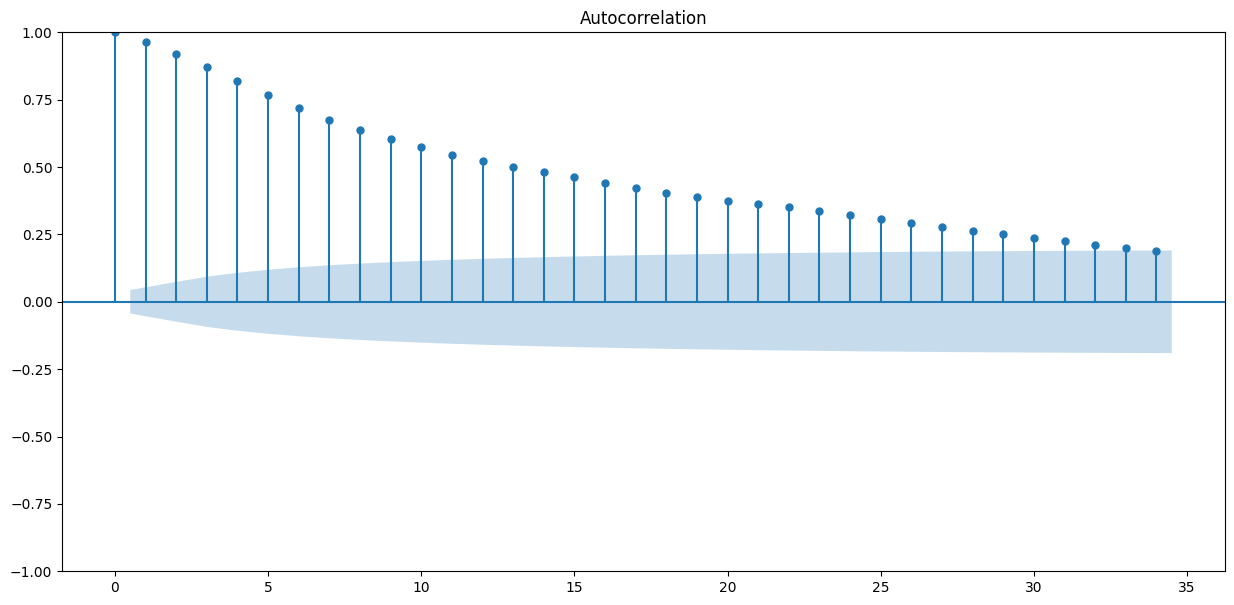

In [19]:
# Plot ACF graph
plt.figure(figsize = (15, 7))
ax  = plt.subplot(1, 1, 1)
plot_acf(gen_data_train["value"], ax = ax);

From the results of the ACF plot, the number of lags of the moving average part of an ARIMA model is around 30.

### Compute PACF

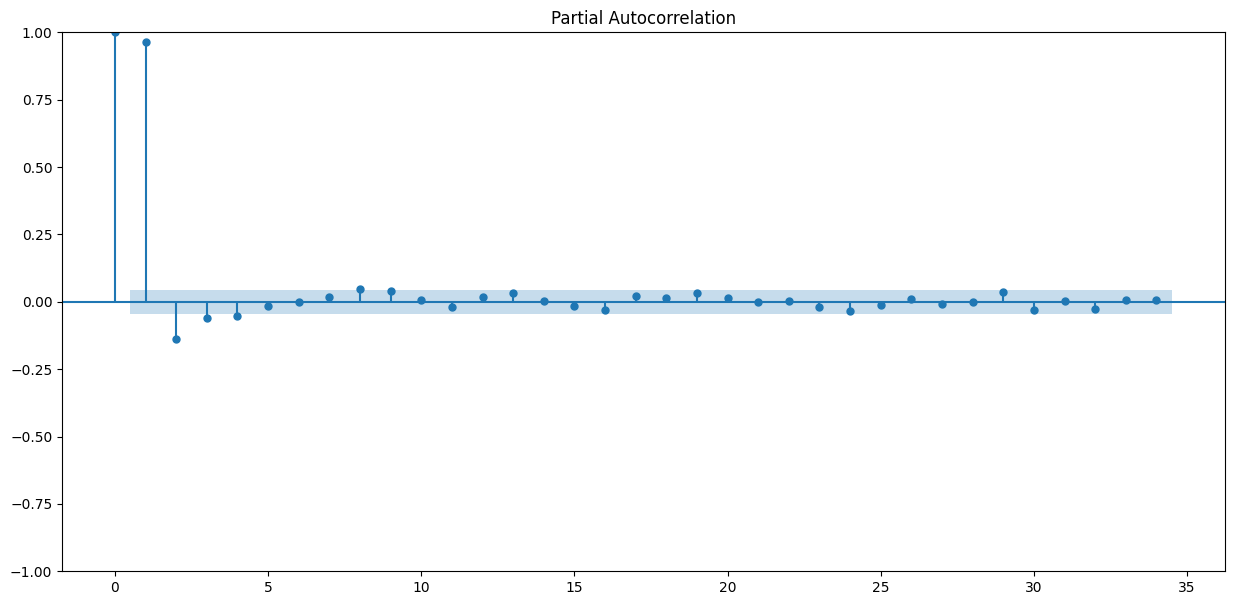

In [20]:
# Plot PACF graph
plt.figure(figsize = (15, 7))
ax  = plt.subplot(1, 1, 1)
plot_pacf(gen_data_train["value"], ax = ax);

From the result of the PACF plot, the number of lags of the autoregresive part of an ARIMA model is 2 or 3.

### Fit and predict with an ARIMA model

In [21]:
# Fit the ARIMA model with the choosen parameters
arima = ARIMA(gen_data_train, order = (2, 0, 1), freq = 'H').fit()
arima.summary()

/home/bender/.pyenv/versions/3.10.6/envs/re_forecast_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                 2015
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -8335.712
Date:                Wed, 12 Jun 2024   AIC                          16681.424
Time:                        23:03:11   BIC                          16709.466
Sample:                    11-02-2023   HQIC                         16691.716
                         - 01-24-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        116.5332      8.546     13.636      0.000      99.783     133.283
ar.L1          1.5491      0.087     17.736      0.000       1.378       1.720
ar.L2         -0.5736      0.084     -6.850      0.000      -0.738      -0.409
ma.L1         -0.4573      0.089     -5.151      0.000      -0.631      -0.283
sigma2       229.1661      3.240     70.739      0.000     222.817     235.516
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             10064.13
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
# Compare the results with the grid search auto-arima
a_arima = auto_arima(gen_data_train["value"],
                     start_p = 1, max_p = 3,
                     start_q = 1, max_q = 10,
                     max_d = 1,
                     seasonal = False,
                     trace = True
                     )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16722.374, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16751.967, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16723.169, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16725.378, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16750.018, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16724.345, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16724.338, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16723.805, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16722.782, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16720.412, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16723.421, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16721.210, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=16722.384, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]  

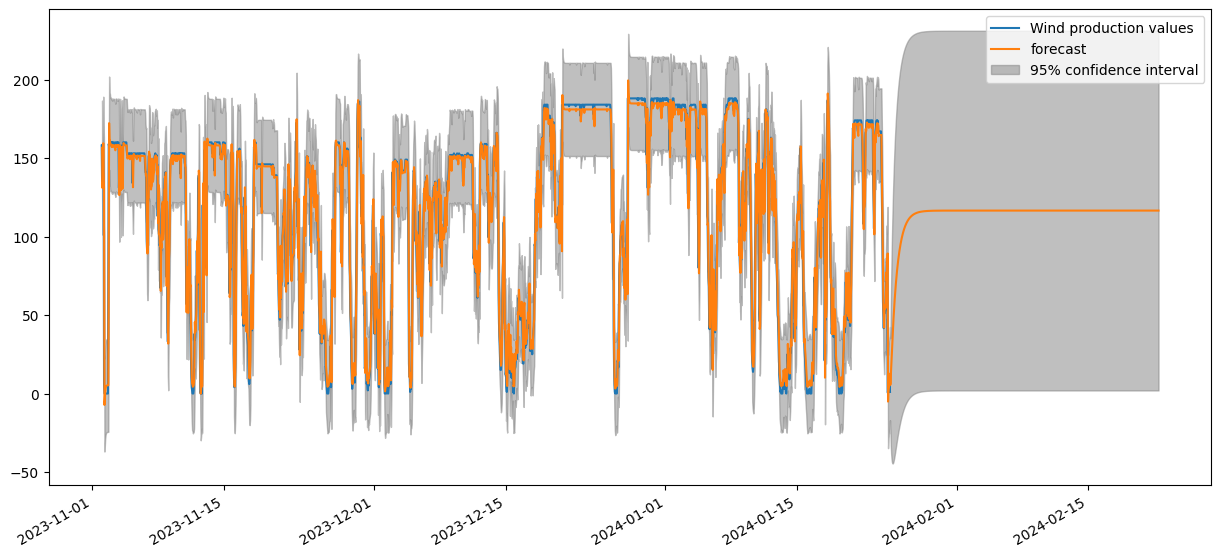

In [23]:
# Glance at our predictions : Use plot-predict
fig, axs = plt.subplots(1, 1, figsize = (15, 7))
axs.plot(gen_data_train["value"], label = "Wind production values")
plot_predict(arima, start = 1, end = 2700, ax = axs);

### Plot the forecast results against test values

In [31]:
# Construct a plot forecast function, that also show the training set
def plot_forecast(fitted_arima: object,
                  train_set: pd.Series,
                  test_set: pd.Series,
                  confidence_prob: float,
                  performance_metric: object,
                  figsize: tuple = (16, 9)
                  ) -> None:
    """Plot the forecast of an ARIMA model compared to the test set, also plot
    the train set values. Compute and show the given performance metric.
    Arguments:
    - fitted_arima: the fitted arima model
    - train_set: the time serie train set as pandas serie
    - test_set: the time serie test set as pandas serie
    - confidence_prob: the confidence probability
    Parameters:
    - figsize: the size of the plot in inches"""

    # Forecast values and the confidence interval
    forecast_results = fitted_arima.get_forecast(len(test_set), alpha = confidence_prob)
    forecast = forecast_results.predicted_mean
    confidence_int = forecast_results.conf_int().values

    # Prepare the forecast, lower and upper confidence bounds series
    forecast_serie = pd.Series(forecast, index = test_set.index)
    lower_serie = pd.Series(confidence_int[:, 0], index = test_set.index)
    upper_serie = pd.Series(confidence_int[:, 1], index = test_set.index)

    # Compute the MAE
    performance_score = performance_metric(test_set, forecast_serie)
    forecast_message = f"Forecast : {performance_metric.__name__} = {performance_score:.2f}"

    # Plot
    plt.figure(figsize = figsize)
    plt.plot(train_set, label = 'Train set', color = 'navy')
    plt.plot(test_set, label = 'Test set', color = 'navy', ls = '--')
    plt.plot(forecast_serie, label = forecast_message, color = 'orange')
    plt.fill_between(lower_serie.index, lower_serie, upper_serie, color = 'k', alpha = 0.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc = 'upper left', fontsize = 10)
    plt.show()

/home/bender/.pyenv/versions/3.10.6/envs/re_forecast_env/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



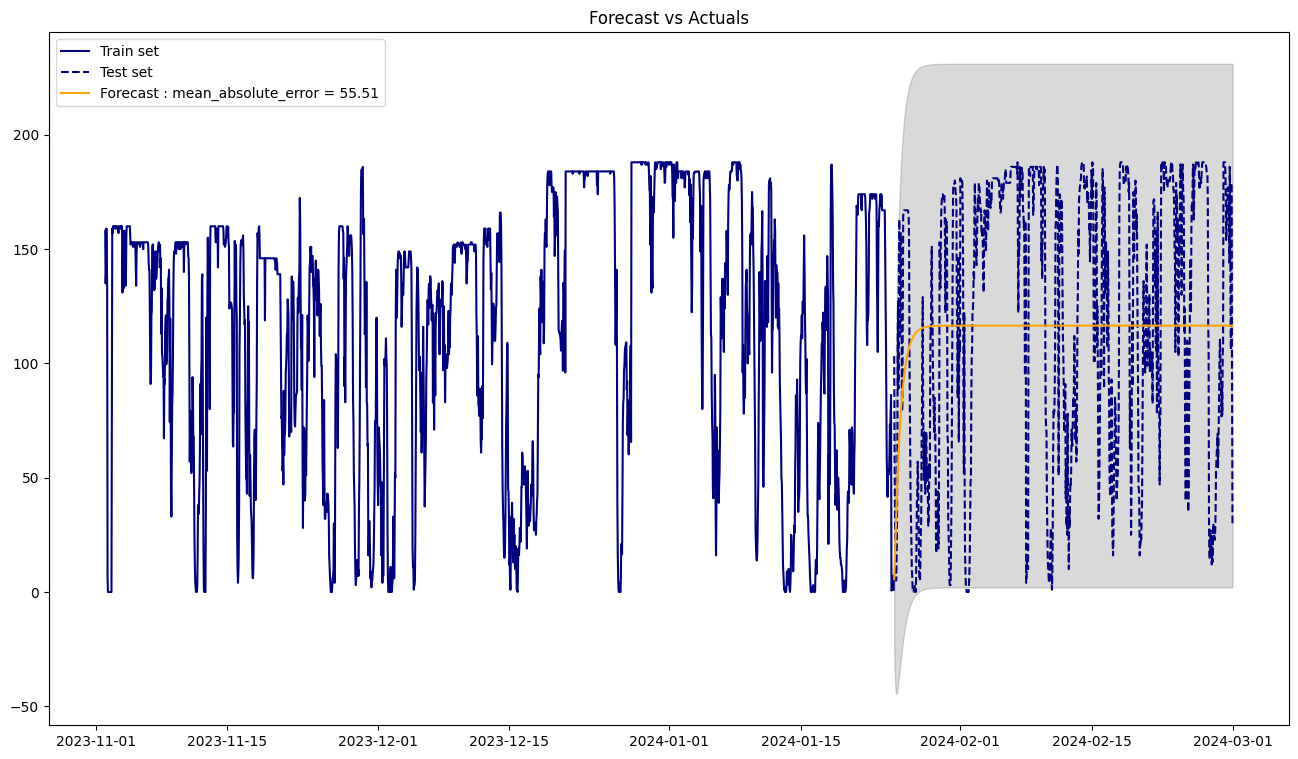

In [32]:
# Plot the forecast
plot_forecast(arima,
              gen_data_train["value"],
              gen_data_test["value"],
              confidence_prob = 0.05,
              performance_metric = mean_absolute_error)